<a href="https://colab.research.google.com/github/vipashaaV321/User-Intent-Modeling/blob/main/NbIP_AND_NbCP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Navigation By Immediate Preference

Recommendation Cycle 1:
[1, 817, 913, 830, 852]
Do you like item 817? [Yes/No/Stop]: Yes
Hit Rate: 0.0
Recommendation Cycle 2:
[1, 913, 830, 852, 1]
Do you like item 830? [Yes/No/Stop]: No
Hit Rate: 0.0
Final Hit Rate: 0.0


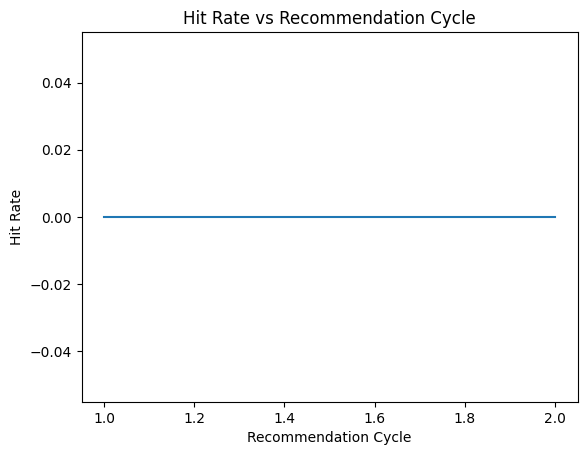

In [ ]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.metrics import pairwise_distances

class NByIP:
    def __init__(self, data, seed_item, n, update_policy, eta=0.5):
        #initialization
        self.data = data
        self.seed_item = seed_item
        self.n = n
        self.update_policy = update_policy
        self.eta = eta
        self.tabu_list = []
        self.selection_consistent_candidates = self.get_neighbours(seed_item)
        self.recommendations = []

    def get_neighbours(self, item_id):
        #consider all neighbors
        return list(self.data[item_id].keys())

    def compute_similarity_matrix(self, items):
        #cosine sim
        return pairwise_distances(items, metric='cosine')

    def overlap_score(self, item_id, selection_candidates, recommendations):

        overlap_selection = set(self.get_neighbours(item_id)).intersection(set(selection_candidates))
        overlap_long_term = set(self.get_neighbours(item_id)) - set(recommendations)
        #score func with short term and long term Modeling
        #short term
        score_selection = (1 - self.eta) * len(overlap_selection) / (len(self.get_neighbours(item_id)) + len(overlap_long_term))
        #long term
        score_long_term = self.eta * len(overlap_long_term) / (len(self.get_neighbours(item_id)) + len(overlap_long_term))
        return score_selection + score_long_term

    def recommend(self):
        #candidates
        candidates = self.selection_consistent_candidates[:]
        while len(self.recommendations) < self.n and len(candidates) > 0:
          #score
            scores = [self.overlap_score(item_id, self.selection_consistent_candidates, self.recommendations) for item_id in candidates]
            #take indiec
            max_index = np.argmax(scores)
            max_item = candidates[max_index]
            #append to recomm. list
            self.recommendations.append(max_item)
            candidates.remove(max_item)
        return self.recommendations

    def update_selection_consistent_candidates(self, selected_item, rejected_items):
        if self.update_policy == 'Strict':
            self.selection_consistent_candidates = list(set(self.selection_consistent_candidates) - set(rejected_items))
        elif self.update_policy == 'Relaxed':
            self.selection_consistent_candidates = list(set(self.selection_consistent_candidates) - set(rejected_items))
        elif self.update_policy == 'Open':
            pass
        elif self.update_policy == 'Mean':
            similarities = defaultdict(list)
            for rejected_item in rejected_items:
                for neighbour in self.get_neighbours(rejected_item):
                    if neighbour in self.data[selected_item]:
                        similarities[neighbour].append(self.data[rejected_item][neighbour])
            mean_similarities = {item_id: np.mean(similarity_list) for item_id, similarity_list in similarities.items()}
            self.selection_consistent_candidates = [item_id for item_id in self.selection_consistent_candidates if
                                                    item_id in mean_similarities and self.data[selected_item][item_id] >= mean_similarities[item_id]]
        elif self.update_policy == 'Max':
            similarities = defaultdict(list)
            for rejected_item in rejected_items:
                for neighbour in self.get_neighbours(rejected_item):
                    if neighbour in self.data[selected_item]:
                        similarities[neighbour].append(self.data[rejected_item][neighbour])
            max_similarities = {item_id: np.max(similarity_list) for item_id, similarity_list in similarities.items()}
            self.selection_consistent_candidates = [item_id for item_id in self.selection_consistent_candidates if
                                                    item_id in max_similarities and self.data[selected_item][item_id] >= max_similarities[item_id]]

    def run(self):
        hit_rates = []
        cycle = 1
        while len(self.selection_consistent_candidates) > self.n:
            recommendations = self.recommend()
            print(f'Recommendation Cycle {cycle}:')
            print(recommendations)
            #select random item
            selected_item = random.choice(recommendations)
            #feedback
            action = input(f"Do you like item {selected_item}? [Yes/No/Stop]: ")
            if action.upper() == 'STOP':
                self.tabu_list.extend(recommendations)
                break
            elif action.upper() == 'YES':
                #recommended item are added to tabu
                self.tabu_list.append(selected_item)
                self.recommendations.remove(selected_item)
            elif action.upper() == 'NO':
                #update consistent candidates
                self.update_selection_consistent_candidates(selected_item, [selected_item])
                self.recommendations.remove(selected_item)
            hit_rate = len(set(self.tabu_list) & set(self.recommendations)) / self.n
            hit_rates.append(hit_rate)
            print(f'Hit Rate: {hit_rate}')
            cycle += 1
        return hit_rates

def load_data(data_path):
    data = defaultdict(dict)
    columns = ['user_id', 'item_id', 'rating', 'timestamp']
    df = pd.read_csv(data_path, sep='\t', names=columns, header=None)
    for _, row in df.iterrows():
        user_id = row['user_id']
        item_id = row['item_id']
        rating = row['rating']
        data[item_id][user_id] = rating
    return data

def plot_hit_rate(hit_rates):
    plt.plot(range(1, len(hit_rates) + 1), hit_rates)
    plt.xlabel('Recommendation Cycle')
    plt.ylabel('Hit Rate')
    plt.title('Hit Rate vs Recommendation Cycle')
    plt.show()

def main():
    data_path = '/content/drive/MyDrive/Data/movie-lens/u.data'
    data = load_data(data_path)

    seed_item = 1
    n = 5
    update_policy = 'Mean'

    algorithm = NByIP(data, seed_item, n, update_policy)
    hit_rates = algorithm.run()
    print('Final Hit Rate:', hit_rates[-1])

    plot_hit_rate(hit_rates)

if __name__ == '__main__':
    main()


# Navigation by Cumulative Preference

## eta:0.5, SMEAN

Recommendation Cycle 1:
[308, 287, 148, 280, 66]
Do you like item 66? [Yes/No/Stop]: Yes
Hit Rate: 0.8
Recommendation Cycle 2:
[308, 287, 148, 280, 148]
Do you like item 308? [Yes/No/Stop]: Yes
Hit Rate: 0.6
Recommendation Cycle 3:
[287, 148, 280, 148, 268]
Do you like item 280? [Yes/No/Stop]: Yes
Hit Rate: 0.6
Recommendation Cycle 4:
[287, 148, 148, 268, 268]
Do you like item 268? [Yes/No/Stop]: Stop
Final Hit Rate: 0.6


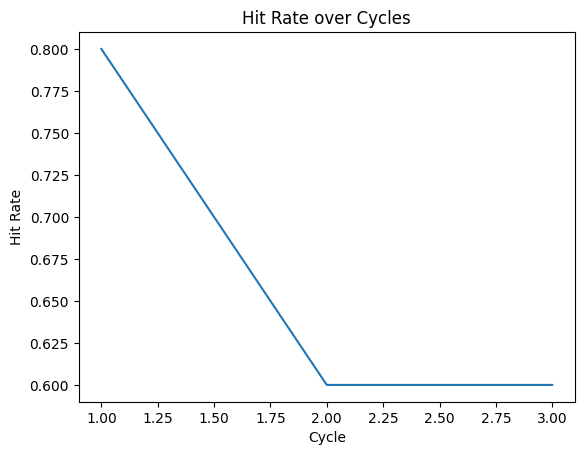

In [ ]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.metrics import pairwise_distances

class NByCP:
    def __init__(self, data, seed_item, n, reweighting_policy, eta=0.25):
        self.data = data
        self.seed_item = seed_item
        self.n = n
        self.reweighting_policy = reweighting_policy
        self.eta = eta
        self.selection_consistent_candidates = self.get_neighbours(seed_item)
        self.recommendations = []
        self.item_weights = defaultdict(float)

    def get_neighbours(self, item_id):
        return list(self.data[item_id].keys())

    def compute_similarity_matrix(self, items):
      unique_features = set()
      for item_id in items:
        unique_features.update(self.data[item_id].values())

      num_items = len(items)
      num_features = len(unique_features)
      feature_mapping = {feature: i for i, feature in enumerate(unique_features)}

      item_features = np.zeros((num_items, num_features))
      for i, item_id in enumerate(items):
        for feature in self.data[item_id].values():
            feature_idx = feature_mapping[feature]
            item_features[i, feature_idx] = 1

      return pairwise_distances(item_features, metric='cosine')


    def overlap_score(self, item_id, selection_candidates, long_term_candidates, recommendations):
        overlap_selection = set(self.get_neighbours(item_id)).intersection(set(selection_candidates))
        overlap_long_term = set(self.get_neighbours(item_id)).intersection(set(long_term_candidates)) - set(recommendations)
        numerator = 2 * sum(self.item_weights[neighbour] for neighbour in overlap_selection)
        denominator = sum(self.item_weights[neighbour] for neighbour in self.get_neighbours(item_id)) + sum(self.item_weights[neighbour] for neighbour in overlap_long_term)
        if denominator == 0:
          return 0
        return numerator / denominator

    def recommend(self):
        #take consitent candidate itemss
        candidates = self.selection_consistent_candidates[:]
        #while no. of recomm achieved
        while len(self.recommendations) < self.n and len(candidates) > 0:
            #take score
            scores = [self.overlap_score(item_id, self.selection_consistent_candidates,
                                         self.data.keys(), self.recommendations) for item_id in candidates]
            #take indexed where scores are given
            max_index = np.argmax(scores)
            #take that item from cand.
            max_item = candidates[max_index]
            #append to recomm list
            self.recommendations.append(max_item)
            #remove recommended items from cand.list
            candidates.remove(max_item)
        return self.recommendations

    def update_selection_consistent_candidates(self, selected_item, rejected_items, update_policy):
        if update_policy == 'Open':
            self.selection_consistent_candidates = self.get_neighbours(selected_item)

    def reweight_items(self, selected_item, rejected_items, reweighting_policy):
        if reweighting_policy == 'Directional':
            for item_id in self.data.keys():
                if item_id == selected_item:
                    self.item_weights[item_id] += 1
                elif item_id in rejected_items:
                    self.item_weights[item_id] -= 1
        elif reweighting_policy == 'Similarity':
            similarities = self.compute_similarity_matrix([selected_item] + rejected_items)
            for item_id in self.data.keys():
                if item_id == selected_item:
                    self.item_weights[item_id] += similarities[0][0]
                elif item_id in rejected_items:
                    index = rejected_items.index(item_id) + 1
                    self.item_weights[item_id] -= similarities[0][index]
        elif reweighting_policy == 'Similarity-Mean':
            similarities = self.compute_similarity_matrix([selected_item] + rejected_items)
            mean_similarity = np.mean(similarities[0][1:])
            for item_id in self.data.keys():
                if item_id == selected_item:
                    self.item_weights[item_id] += similarities[0][0]
                elif item_id in rejected_items:
                    index = rejected_items.index(item_id) + 1
                    self.item_weights[item_id] -= mean_similarity * similarities[0][index]
        elif reweighting_policy == 'Similarity-Max':
            similarities = self.compute_similarity_matrix([selected_item] + rejected_items)
            max_similarity = np.max(similarities[0][1:])
            for item_id in self.data.keys():
                if item_id == selected_item:
                    self.item_weights[item_id] += similarities[0][0]
                elif item_id in rejected_items:
                    index = rejected_items.index(item_id) + 1
                    self.item_weights[item_id] -= max_similarity * similarities[0][index]
        elif reweighting_policy == 'Recency':
            depth = len(self.recommendations)
            for item_id in self.data.keys():
                if item_id == selected_item:
                    self.item_weights[item_id] += 1 / depth
                elif item_id in rejected_items:
                    index = rejected_items.index(item_id)
                    self.item_weights[item_id] -= 1 / depth * similarities[0][index]
        elif reweighting_policy == 'Recency-Mean':
            depth = len(self.recommendations)
            similarities = self.compute_similarity_matrix([selected_item] + rejected_items)
            mean_similarity = np.mean(similarities[0])
            for item_id in self.data.keys():
                if item_id == selected_item:
                    self.item_weights[item_id] += 1 / depth
                elif item_id in rejected_items:
                    index = rejected_items.index(item_id)
                    self.item_weights[item_id] -= 1 / depth * mean_similarity * similarities[0][index]
        elif reweighting_policy == 'Recency-Max':
            depth = len(self.recommendations)
            similarities = self.compute_similarity_matrix([selected_item] + rejected_items)
            max_similarity = np.max(similarities[0])
            for item_id in self.data.keys():
                if item_id == selected_item:
                    self.item_weights[item_id] += 1 / depth
                elif item_id in rejected_items:
                    index = rejected_items.index(item_id)
                    self.item_weights[item_id] -= 1 / depth * max_similarity * similarities[0][index]

    def run(self):
        hit_rates = []
        cycle = 1
        while len(self.selection_consistent_candidates) > self.n:
            recommendations = self.recommend()
            print(f'Recommendation Cycle {cycle}:')
            print(recommendations)
            selected_item = random.choice(recommendations)
            action = input(f"Do you like item {selected_item}? [Yes/No/Stop]: ")
            if action.upper() == 'STOP':
                self.recommendations.remove(selected_item)
                break
            elif action.upper() == 'YES':
                self.recommendations.remove(selected_item)
            elif action.upper() == 'NO':
                self.update_selection_consistent_candidates(selected_item, [selected_item], 'Open')
                self.recommendations.remove(selected_item)
            self.reweight_items(selected_item, self.recommendations, self.reweighting_policy)
            hit_rate = len(set(self.recommendations) & set(self.selection_consistent_candidates)) / self.n
            hit_rates.append(hit_rate)
            print(f'Hit Rate: {hit_rate}')
            cycle += 1
        return hit_rates

def load_data(data_path):
    data = defaultdict(dict)
    columns = ['user_id', 'item_id', 'rating', 'timestamp']
    df = pd.read_csv(data_path, sep='\t', names=columns, header=None)
    for _, row in df.iterrows():
        user_id = row['user_id']
        item_id = row['item_id']
        rating = row['rating']
        data[item_id][user_id] = rating
    return data

def plot_hit_rate(hit_rates):
    plt.plot(range(1, len(hit_rates) + 1), hit_rates)
    plt.xlabel('Cycle')
    plt.ylabel('Hit Rate')
    plt.title('Hit Rate over Cycles')
    plt.show()

def main():
    data_path = '/content/drive/MyDrive/Data/movie-lens/u.data'
    data = load_data(data_path)

    seed_item = 1
    n = 5
    reweighting_policy = 'Similarity-Mean'

    rs = NByCP(data, seed_item, n, reweighting_policy)
    hit_rates = rs.run()
    print('Final Hit Rate:', hit_rates[-1])

    plot_hit_rate(hit_rates)

if __name__ == '__main__':
    main()


## eta: 0.25

Recommendation Cycle 1:
[308, 287, 148, 280, 66]
Do you like item 308? [Yes/No/Stop]: Yes
Hit Rate: 0.8
Recommendation Cycle 2:
[287, 148, 280, 66, 280]
Do you like item 280? [Yes/No/Stop]: No
Hit Rate: 0.2
Recommendation Cycle 3:
[287, 148, 66, 280, 15]
Do you like item 287? [Yes/No/Stop]: No
Hit Rate: 0.0
Recommendation Cycle 4:
[148, 66, 280, 15, 306]
Do you like item 66? [Yes/No/Stop]: Yes
Hit Rate: 0.2
Recommendation Cycle 5:
[148, 280, 15, 306, 321]
Do you like item 306? [Yes/No/Stop]: Stop
Avg Hit Rate: 0.24


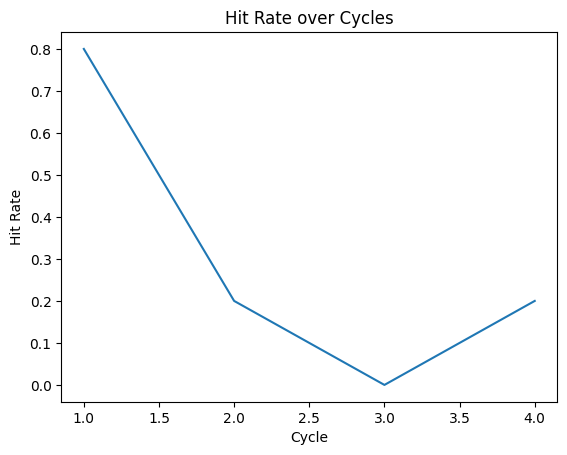

In [ ]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.metrics import pairwise_distances

class NByCP:
    def __init__(self, data, seed_item, n, reweighting_policy, eta=0.25):
        self.data = data
        self.seed_item = seed_item
        self.n = n
        self.reweighting_policy = reweighting_policy
        self.eta = eta
        self.selection_consistent_candidates = self.get_neighbours(seed_item)
        self.recommendations = []
        self.item_weights = defaultdict(float)

    def get_neighbours(self, item_id):
        return list(self.data[item_id].keys())

    def compute_similarity_matrix(self, items):
      unique_features = set()
      for item_id in items:
        unique_features.update(self.data[item_id].values())

      num_items = len(items)
      num_features = len(unique_features)
      feature_mapping = {feature: i for i, feature in enumerate(unique_features)}

      item_features = np.zeros((num_items, num_features))
      for i, item_id in enumerate(items):
        for feature in self.data[item_id].values():
            feature_idx = feature_mapping[feature]
            item_features[i, feature_idx] = 1

      return pairwise_distances(item_features, metric='cosine')


    def overlap_score(self, item_id, selection_candidates, long_term_candidates, recommendations):
        overlap_selection = set(self.get_neighbours(item_id)).intersection(set(selection_candidates))
        overlap_long_term = set(self.get_neighbours(item_id)).intersection(set(long_term_candidates)) - set(recommendations)
        numerator = 2 * sum(self.item_weights[neighbour] for neighbour in overlap_selection)
        denominator = sum(self.item_weights[neighbour] for neighbour in self.get_neighbours(item_id)) + sum(self.item_weights[neighbour] for neighbour in overlap_long_term)
        if denominator == 0:
          return 0
        return numerator / denominator

    def recommend(self):
        candidates = self.selection_consistent_candidates[:]
        while len(self.recommendations) < self.n and len(candidates) > 0:
            scores = [self.overlap_score(item_id, self.selection_consistent_candidates,
                                         self.data.keys(), self.recommendations) for item_id in candidates]
            max_index = np.argmax(scores)
            max_item = candidates[max_index]
            self.recommendations.append(max_item)
            candidates.remove(max_item)
        return self.recommendations

    def update_selection_consistent_candidates(self, selected_item, rejected_items, update_policy):
        if update_policy == 'Open':
            self.selection_consistent_candidates = self.get_neighbours(selected_item)

    def reweight_items(self, selected_item, rejected_items, reweighting_policy):
        if reweighting_policy == 'Directional':
            for item_id in self.data.keys():
                if item_id == selected_item:
                    self.item_weights[item_id] += 1
                elif item_id in rejected_items:
                    self.item_weights[item_id] -= 1
        elif reweighting_policy == 'Similarity':
            similarities = self.compute_similarity_matrix([selected_item] + rejected_items)
            for item_id in self.data.keys():
                if item_id == selected_item:
                    self.item_weights[item_id] += similarities[0][0]
                elif item_id in rejected_items:
                    index = rejected_items.index(item_id) + 1
                    self.item_weights[item_id] -= similarities[0][index]
        elif reweighting_policy == 'Similarity-Mean':
            similarities = self.compute_similarity_matrix([selected_item] + rejected_items)
            mean_similarity = np.mean(similarities[0][1:])
            for item_id in self.data.keys():
                if item_id == selected_item:
                    self.item_weights[item_id] += similarities[0][0]
                elif item_id in rejected_items:
                    index = rejected_items.index(item_id) + 1
                    self.item_weights[item_id] -= mean_similarity * similarities[0][index]
        elif reweighting_policy == 'Similarity-Max':
            similarities = self.compute_similarity_matrix([selected_item] + rejected_items)
            max_similarity = np.max(similarities[0][1:])
            for item_id in self.data.keys():
                if item_id == selected_item:
                    self.item_weights[item_id] += similarities[0][0]
                elif item_id in rejected_items:
                    index = rejected_items.index(item_id) + 1
                    self.item_weights[item_id] -= max_similarity * similarities[0][index]
        elif reweighting_policy == 'Recency':
            depth = len(self.recommendations)
            for item_id in self.data.keys():
                if item_id == selected_item:
                    self.item_weights[item_id] += 1 / depth
                elif item_id in rejected_items:
                    index = rejected_items.index(item_id)
                    self.item_weights[item_id] -= 1 / depth * similarities[0][index]
        elif reweighting_policy == 'Recency-Mean':
            depth = len(self.recommendations)
            similarities = self.compute_similarity_matrix([selected_item] + rejected_items)
            mean_similarity = np.mean(similarities[0])
            for item_id in self.data.keys():
                if item_id == selected_item:
                    self.item_weights[item_id] += 1 / depth
                elif item_id in rejected_items:
                    index = rejected_items.index(item_id)
                    self.item_weights[item_id] -= 1 / depth * mean_similarity * similarities[0][index]
        elif reweighting_policy == 'Recency-Max':
            depth = len(self.recommendations)
            similarities = self.compute_similarity_matrix([selected_item] + rejected_items)
            max_similarity = np.max(similarities[0])
            for item_id in self.data.keys():
                if item_id == selected_item:
                    self.item_weights[item_id] += 1 / depth
                elif item_id in rejected_items:
                    index = rejected_items.index(item_id)
                    self.item_weights[item_id] -= 1 / depth * max_similarity * similarities[0][index]

    def run(self):
        hit_rates = []
        cycle = 1
        while len(self.selection_consistent_candidates) > self.n:
            recommendations = self.recommend()
            print(f'Recommendation Cycle {cycle}:')
            print(recommendations)
            selected_item = random.choice(recommendations)
            action = input(f"Do you like item {selected_item}? [Yes/No/Stop]: ")
            if action.upper() == 'STOP':
                self.recommendations.remove(selected_item)
                break
            elif action.upper() == 'YES':
                self.recommendations.remove(selected_item)
            elif action.upper() == 'NO':
                self.update_selection_consistent_candidates(selected_item, [selected_item], 'Open')
                self.recommendations.remove(selected_item)
            self.reweight_items(selected_item, self.recommendations, self.reweighting_policy)
            hit_rate = len(set(self.recommendations) & set(self.selection_consistent_candidates)) / self.n
            hit_rates.append(hit_rate)
            print(f'Hit Rate: {hit_rate}')
            cycle += 1
        return hit_rates

def load_data(data_path):
    data = defaultdict(dict)
    columns = ['user_id', 'item_id', 'rating', 'timestamp']
    df = pd.read_csv(data_path, sep='\t', names=columns, header=None)
    for _, row in df.iterrows():
        user_id = row['user_id']
        item_id = row['item_id']
        rating = row['rating']
        data[item_id][user_id] = rating
    return data

def plot_hit_rate(hit_rates):
    plt.plot(range(1, len(hit_rates) + 1), hit_rates)
    plt.xlabel('Cycle')
    plt.ylabel('Hit Rate')
    plt.title('Hit Rate over Cycles')
    plt.show()

def main():
    data_path = '/content/drive/MyDrive/Data/movie-lens/u.data'
    data = load_data(data_path)

    seed_item = 1
    n = 5
    reweighting_policy = 'Similarity-Mean'

    rs = NByCP(data, seed_item, n, reweighting_policy)
    hit_rates = rs.run()
    print('Avg Hit Rate:', sum(hit_rates)/n)

    plot_hit_rate(hit_rates)

if __name__ == '__main__':
    main()


## eta: 0.75

Recommendation Cycle 1:
[286, 313, 233, 291, 280]
Do you like item 291? [Yes/No/Stop]: Yes 
Hit Rate: 1.0
Recommendation Cycle 2:
[286, 313, 233, 291, 280]
Do you like item 286? [Yes/No/Stop]: Yes
Hit Rate: 0.8
Recommendation Cycle 3:
[313, 233, 291, 280, 286]
Do you like item 280? [Yes/No/Stop]: No
Hit Rate: 0.2
Recommendation Cycle 4:
[313, 233, 291, 286, 81]
Do you like item 233? [Yes/No/Stop]: Yes
Hit Rate: 0.4
Recommendation Cycle 5:
[313, 291, 286, 81, 81]
Do you like item 313? [Yes/No/Stop]: Yes
Hit Rate: 0.4
Recommendation Cycle 6:
[291, 286, 81, 81, 81]
Do you like item 81? [Yes/No/Stop]: No
Hit Rate: 0.2
Recommendation Cycle 7:
[291, 286, 81, 81, 329]
Do you like item 81? [Yes/No/Stop]: Stop
Avg Hit Rate: 0.6


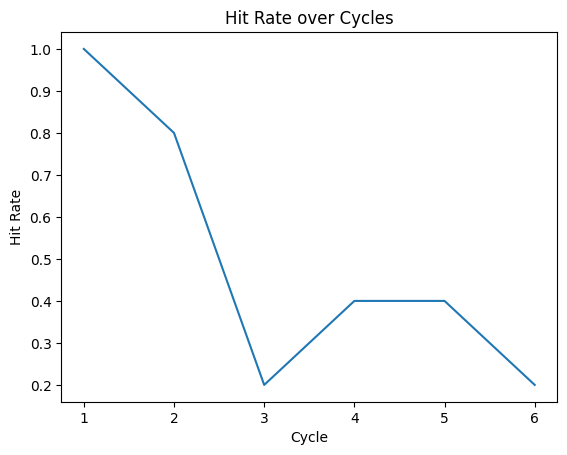

In [ ]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.metrics import pairwise_distances

class NByCP:
    def __init__(self, data, seed_item, n, reweighting_policy, eta=0.75):
        self.data = data
        self.seed_item = seed_item
        self.n = n
        self.reweighting_policy = reweighting_policy
        self.eta = eta
        self.selection_consistent_candidates = self.get_neighbours(seed_item)
        self.recommendations = []
        self.item_weights = defaultdict(float)

    def get_neighbours(self, item_id):
        return list(self.data[item_id].keys())

    def compute_similarity_matrix(self, items):
      unique_features = set()
      for item_id in items:
        unique_features.update(self.data[item_id].values())

      num_items = len(items)
      num_features = len(unique_features)
      feature_mapping = {feature: i for i, feature in enumerate(unique_features)}

      item_features = np.zeros((num_items, num_features))
      for i, item_id in enumerate(items):
        for feature in self.data[item_id].values():
            feature_idx = feature_mapping[feature]
            item_features[i, feature_idx] = 1

      return pairwise_distances(item_features, metric='cosine')


    def overlap_score(self, item_id, selection_candidates, long_term_candidates, recommendations):
        overlap_selection = set(self.get_neighbours(item_id)).intersection(set(selection_candidates))
        overlap_long_term = set(self.get_neighbours(item_id)).intersection(set(long_term_candidates)) - set(recommendations)
        numerator = 2 * sum(self.item_weights[neighbour] for neighbour in overlap_selection)
        denominator = sum(self.item_weights[neighbour] for neighbour in self.get_neighbours(item_id)) + sum(self.item_weights[neighbour] for neighbour in overlap_long_term)
        if denominator == 0:
          return 0
        return numerator / denominator

    def recommend(self):
        candidates = self.selection_consistent_candidates[:]
        while len(self.recommendations) < self.n and len(candidates) > 0:
            scores = [self.overlap_score(item_id, self.selection_consistent_candidates,
                                         self.data.keys(), self.recommendations) for item_id in candidates]
            max_index = np.argmax(scores)
            max_item = candidates[max_index]
            self.recommendations.append(max_item)
            candidates.remove(max_item)
        return self.recommendations

    def update_selection_consistent_candidates(self, selected_item, rejected_items, update_policy):
        if update_policy == 'Open':
            self.selection_consistent_candidates = self.get_neighbours(selected_item)

    def reweight_items(self, selected_item, rejected_items, reweighting_policy):
        if reweighting_policy == 'Directional':
            for item_id in self.data.keys():
                if item_id == selected_item:
                    self.item_weights[item_id] += 1
                elif item_id in rejected_items:
                    self.item_weights[item_id] -= 1
        elif reweighting_policy == 'Similarity':
            similarities = self.compute_similarity_matrix([selected_item] + rejected_items)
            for item_id in self.data.keys():
                if item_id == selected_item:
                    self.item_weights[item_id] += similarities[0][0]
                elif item_id in rejected_items:
                    index = rejected_items.index(item_id) + 1
                    self.item_weights[item_id] -= similarities[0][index]
        elif reweighting_policy == 'Similarity-Mean':
            similarities = self.compute_similarity_matrix([selected_item] + rejected_items)
            mean_similarity = np.mean(similarities[0][1:])
            for item_id in self.data.keys():
                if item_id == selected_item:
                    self.item_weights[item_id] += similarities[0][0]
                elif item_id in rejected_items:
                    index = rejected_items.index(item_id) + 1
                    self.item_weights[item_id] -= mean_similarity * similarities[0][index]
        elif reweighting_policy == 'Similarity-Max':
            similarities = self.compute_similarity_matrix([selected_item] + rejected_items)
            max_similarity = np.max(similarities[0][1:])
            for item_id in self.data.keys():
                if item_id == selected_item:
                    self.item_weights[item_id] += similarities[0][0]
                elif item_id in rejected_items:
                    index = rejected_items.index(item_id) + 1
                    self.item_weights[item_id] -= max_similarity * similarities[0][index]
        elif reweighting_policy == 'Recency':
            depth = len(self.recommendations)
            for item_id in self.data.keys():
                if item_id == selected_item:
                    self.item_weights[item_id] += 1 / depth
                elif item_id in rejected_items:
                    index = rejected_items.index(item_id)
                    self.item_weights[item_id] -= 1 / depth * similarities[0][index]
        elif reweighting_policy == 'Recency-Mean':
            depth = len(self.recommendations)
            similarities = self.compute_similarity_matrix([selected_item] + rejected_items)
            mean_similarity = np.mean(similarities[0])
            for item_id in self.data.keys():
                if item_id == selected_item:
                    self.item_weights[item_id] += 1 / depth
                elif item_id in rejected_items:
                    index = rejected_items.index(item_id)
                    self.item_weights[item_id] -= 1 / depth * mean_similarity * similarities[0][index]
        elif reweighting_policy == 'Recency-Max':
            depth = len(self.recommendations)
            similarities = self.compute_similarity_matrix([selected_item] + rejected_items)
            max_similarity = np.max(similarities[0])
            for item_id in self.data.keys():
                if item_id == selected_item:
                    self.item_weights[item_id] += 1 / depth
                elif item_id in rejected_items:
                    index = rejected_items.index(item_id)
                    self.item_weights[item_id] -= 1 / depth * max_similarity * similarities[0][index]

    def run(self):
        hit_rates = []
        cycle = 1
        while len(self.selection_consistent_candidates) > self.n:
            recommendations = self.recommend()
            print(f'Recommendation Cycle {cycle}:')
            print(recommendations)
            selected_item = random.choice(recommendations)
            action = input(f"Do you like item {selected_item}? [Yes/No/Stop]: ")
            if action.upper() == 'STOP':
                self.recommendations.remove(selected_item)
                break
            elif action.upper() == 'YES':
                self.recommendations.remove(selected_item)
            elif action.upper() == 'NO':
                self.update_selection_consistent_candidates(selected_item, [selected_item], 'Open')
                self.recommendations.remove(selected_item)
            self.reweight_items(selected_item, self.recommendations, self.reweighting_policy)
            hit_rate = len(set(self.recommendations) & set(self.selection_consistent_candidates)) / self.n
            hit_rates.append(hit_rate)
            print(f'Hit Rate: {hit_rate}')
            cycle += 1
        return hit_rates

def load_data(data_path):
    data = defaultdict(dict)
    columns = ['user_id', 'item_id', 'rating', 'timestamp']
    df = pd.read_csv(data_path, sep='\t', names=columns, header=None)
    for _, row in df.iterrows():
        user_id = row['user_id']
        item_id = row['item_id']
        rating = row['rating']
        data[item_id][user_id] = rating
    return data

def plot_hit_rate(hit_rates):
    plt.plot(range(1, len(hit_rates) + 1), hit_rates)
    plt.xlabel('Cycle')
    plt.ylabel('Hit Rate')
    plt.title('Hit Rate over Cycles')
    plt.show()

def main():
    data_path = '/content/drive/MyDrive/Data/movie-lens/u.data'
    data = load_data(data_path)

    seed_item = 99
    n = 5
    reweighting_policy = 'Similarity-Mean'

    rs = NByCP(data, seed_item, n, reweighting_policy)
    hit_rates = rs.run()
    print('Avg Hit Rate:', sum(hit_rates)/n)

    plot_hit_rate(hit_rates)

if __name__ == '__main__':
    main()


## eta:0

Recommendation Cycle 1:
[308, 287, 148, 280, 66]
Do you like item 148? [Yes/No/Stop]: Yes
Hit Rate: 0.8
Recommendation Cycle 2:
[308, 287, 280, 66, 148]
Do you like item 66? [Yes/No/Stop]: No
Hit Rate: 0.4
Recommendation Cycle 3:
[308, 287, 280, 148, 13]
Do you like item 287? [Yes/No/Stop]: Yes
Hit Rate: 0.6
Recommendation Cycle 4:
[308, 280, 148, 13, 13]
Do you like item 13? [Yes/No/Stop]: yes
Hit Rate: 0.6
Recommendation Cycle 5:
[308, 280, 148, 13, 13]
Do you like item 308? [Yes/No/Stop]: No
Hit Rate: 0.2
Recommendation Cycle 6:
[280, 148, 13, 13, 360]
Do you like item 13? [Yes/No/Stop]: stop
Avg Hit Rate: 0.5200000000000001


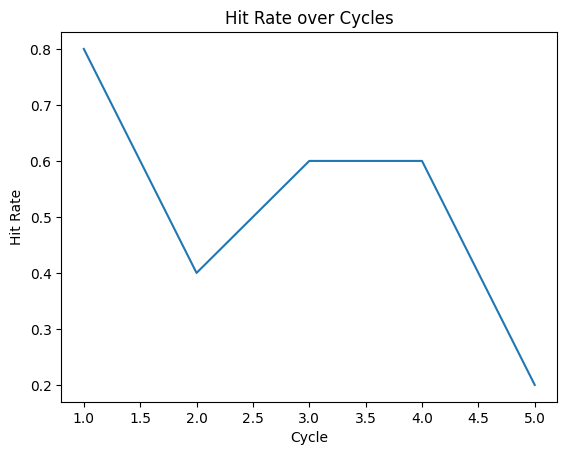

In [ ]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.metrics import pairwise_distances

class NByCP:
    def __init__(self, data, seed_item, n, reweighting_policy, eta=0):
        self.data = data
        self.seed_item = seed_item
        self.n = n
        self.reweighting_policy = reweighting_policy
        self.eta = eta
        self.selection_consistent_candidates = self.get_neighbours(seed_item)
        self.recommendations = []
        self.item_weights = defaultdict(float)

    def get_neighbours(self, item_id):
        return list(self.data[item_id].keys())

    def compute_similarity_matrix(self, items):
      unique_features = set()
      for item_id in items:
        unique_features.update(self.data[item_id].values())

      num_items = len(items)
      num_features = len(unique_features)
      feature_mapping = {feature: i for i, feature in enumerate(unique_features)}

      item_features = np.zeros((num_items, num_features))
      for i, item_id in enumerate(items):
        for feature in self.data[item_id].values():
            feature_idx = feature_mapping[feature]
            item_features[i, feature_idx] = 1

      return pairwise_distances(item_features, metric='cosine')


    def overlap_score(self, item_id, selection_candidates, long_term_candidates, recommendations):
        overlap_selection = set(self.get_neighbours(item_id)).intersection(set(selection_candidates))
        overlap_long_term = set(self.get_neighbours(item_id)).intersection(set(long_term_candidates)) - set(recommendations)
        numerator = 2 * sum(self.item_weights[neighbour] for neighbour in overlap_selection)
        denominator = sum(self.item_weights[neighbour] for neighbour in self.get_neighbours(item_id)) + sum(self.item_weights[neighbour] for neighbour in overlap_long_term)
        if denominator == 0:
          return 0
        return numerator / denominator

    def recommend(self):
        candidates = self.selection_consistent_candidates[:]
        while len(self.recommendations) < self.n and len(candidates) > 0:
            scores = [self.overlap_score(item_id, self.selection_consistent_candidates,
                                         self.data.keys(), self.recommendations) for item_id in candidates]
            max_index = np.argmax(scores)
            max_item = candidates[max_index]
            self.recommendations.append(max_item)
            candidates.remove(max_item)
        return self.recommendations

    def update_selection_consistent_candidates(self, selected_item, rejected_items, update_policy):
        if update_policy == 'Open':
            self.selection_consistent_candidates = self.get_neighbours(selected_item)

    def reweight_items(self, selected_item, rejected_items, reweighting_policy):
        if reweighting_policy == 'Directional':
            for item_id in self.data.keys():
                if item_id == selected_item:
                    self.item_weights[item_id] += 1
                elif item_id in rejected_items:
                    self.item_weights[item_id] -= 1
        elif reweighting_policy == 'Similarity':
            similarities = self.compute_similarity_matrix([selected_item] + rejected_items)
            for item_id in self.data.keys():
                if item_id == selected_item:
                    self.item_weights[item_id] += similarities[0][0]
                elif item_id in rejected_items:
                    index = rejected_items.index(item_id) + 1
                    self.item_weights[item_id] -= similarities[0][index]
        elif reweighting_policy == 'Similarity-Mean':
            similarities = self.compute_similarity_matrix([selected_item] + rejected_items)
            mean_similarity = np.mean(similarities[0][1:])
            for item_id in self.data.keys():
                if item_id == selected_item:
                    self.item_weights[item_id] += similarities[0][0]
                elif item_id in rejected_items:
                    index = rejected_items.index(item_id) + 1
                    self.item_weights[item_id] -= mean_similarity * similarities[0][index]
        elif reweighting_policy == 'Similarity-Max':
            similarities = self.compute_similarity_matrix([selected_item] + rejected_items)
            max_similarity = np.max(similarities[0][1:])
            for item_id in self.data.keys():
                if item_id == selected_item:
                    self.item_weights[item_id] += similarities[0][0]
                elif item_id in rejected_items:
                    index = rejected_items.index(item_id) + 1
                    self.item_weights[item_id] -= max_similarity * similarities[0][index]
        elif reweighting_policy == 'Recency':
            depth = len(self.recommendations)
            for item_id in self.data.keys():
                if item_id == selected_item:
                    self.item_weights[item_id] += 1 / depth
                elif item_id in rejected_items:
                    index = rejected_items.index(item_id)
                    self.item_weights[item_id] -= 1 / depth * similarities[0][index]
        elif reweighting_policy == 'Recency-Mean':
            depth = len(self.recommendations)
            similarities = self.compute_similarity_matrix([selected_item] + rejected_items)
            mean_similarity = np.mean(similarities[0])
            for item_id in self.data.keys():
                if item_id == selected_item:
                    self.item_weights[item_id] += 1 / depth
                elif item_id in rejected_items:
                    index = rejected_items.index(item_id)
                    self.item_weights[item_id] -= 1 / depth * mean_similarity * similarities[0][index]
        elif reweighting_policy == 'Recency-Max':
            depth = len(self.recommendations)
            similarities = self.compute_similarity_matrix([selected_item] + rejected_items)
            max_similarity = np.max(similarities[0])
            for item_id in self.data.keys():
                if item_id == selected_item:
                    self.item_weights[item_id] += 1 / depth
                elif item_id in rejected_items:
                    index = rejected_items.index(item_id)
                    self.item_weights[item_id] -= 1 / depth * max_similarity * similarities[0][index]

    def run(self):
        hit_rates = []
        cycle = 1
        while len(self.selection_consistent_candidates) > self.n:
            recommendations = self.recommend()
            print(f'Recommendation Cycle {cycle}:')
            print(recommendations)
            selected_item = random.choice(recommendations)
            action = input(f"Do you like item {selected_item}? [Yes/No/Stop]: ")
            if action.upper() == 'STOP':
                self.recommendations.remove(selected_item)
                break
            elif action.upper() == 'YES':
                self.recommendations.remove(selected_item)
            elif action.upper() == 'NO':
                self.update_selection_consistent_candidates(selected_item, [selected_item], 'Open')
                self.recommendations.remove(selected_item)
            self.reweight_items(selected_item, self.recommendations, self.reweighting_policy)
            hit_rate = len(set(self.recommendations) & set(self.selection_consistent_candidates)) / self.n
            hit_rates.append(hit_rate)
            print(f'Hit Rate: {hit_rate}')
            cycle += 1
        return hit_rates

def load_data(data_path):
    data = defaultdict(dict)
    columns = ['user_id', 'item_id', 'rating', 'timestamp']
    df = pd.read_csv(data_path, sep='\t', names=columns, header=None)
    for _, row in df.iterrows():
        user_id = row['user_id']
        item_id = row['item_id']
        rating = row['rating']
        data[item_id][user_id] = rating
    return data

def plot_hit_rate(hit_rates):
    plt.plot(range(1, len(hit_rates) + 1), hit_rates)
    plt.xlabel('Cycle')
    plt.ylabel('Hit Rate')
    plt.title('Hit Rate over Cycles')
    plt.show()

def main():
    data_path = '/content/drive/MyDrive/Data/movie-lens/u.data'
    data = load_data(data_path)

    seed_item = 1
    n = 5
    reweighting_policy = 'Similarity-Mean'

    rs = NByCP(data, seed_item, n, reweighting_policy)
    hit_rates = rs.run()
    print('Avg Hit Rate:', sum(hit_rates)/n)

    plot_hit_rate(hit_rates)

if __name__ == '__main__':
    main()


## eta:1

Recommendation Cycle 1:
[308, 287, 148, 280, 66]
Do you like item 287? [Yes/No/Stop]: Yes
Hit Rate: 0.8
Recommendation Cycle 2:
[308, 148, 280, 66, 148]
Do you like item 148? [Yes/No/Stop]: No
Hit Rate: 0.2
Recommendation Cycle 3:
[308, 280, 66, 148, 186]
Do you like item 148? [Yes/No/Stop]: Yes
Hit Rate: 0.4
Recommendation Cycle 4:
[308, 280, 66, 186, 186]
Do you like item 186? [Yes/No/Stop]: No
Hit Rate: 0.2
Recommendation Cycle 5:
[308, 280, 66, 186, 275]
Do you like item 308? [Yes/No/Stop]: stop
Avg Hit Rate: 0.31999999999999995


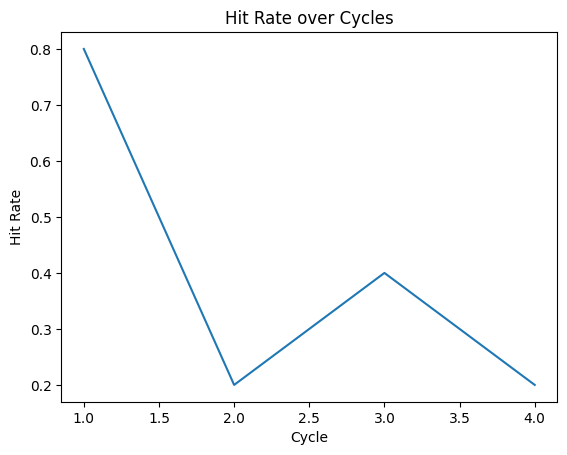

In [ ]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.metrics import pairwise_distances

class NByCP:
    def __init__(self, data, seed_item, n, reweighting_policy, eta=1):
        self.data = data
        self.seed_item = seed_item
        self.n = n
        self.reweighting_policy = reweighting_policy
        self.eta = eta
        self.selection_consistent_candidates = self.get_neighbours(seed_item)
        self.recommendations = []
        self.item_weights = defaultdict(float)

    def get_neighbours(self, item_id):
        return list(self.data[item_id].keys())

    def compute_similarity_matrix(self, items):
      unique_features = set()
      for item_id in items:
        unique_features.update(self.data[item_id].values())

      num_items = len(items)
      num_features = len(unique_features)
      feature_mapping = {feature: i for i, feature in enumerate(unique_features)}

      item_features = np.zeros((num_items, num_features))
      for i, item_id in enumerate(items):
        for feature in self.data[item_id].values():
            feature_idx = feature_mapping[feature]
            item_features[i, feature_idx] = 1

      return pairwise_distances(item_features, metric='cosine')


    def overlap_score(self, item_id, selection_candidates, long_term_candidates, recommendations):
        overlap_selection = set(self.get_neighbours(item_id)).intersection(set(selection_candidates))
        overlap_long_term = set(self.get_neighbours(item_id)).intersection(set(long_term_candidates)) - set(recommendations)
        numerator = 2 * sum(self.item_weights[neighbour] for neighbour in overlap_selection)
        denominator = sum(self.item_weights[neighbour] for neighbour in self.get_neighbours(item_id)) + sum(self.item_weights[neighbour] for neighbour in overlap_long_term)
        if denominator == 0:
          return 0
        return numerator / denominator

    def recommend(self):
        candidates = self.selection_consistent_candidates[:]
        while len(self.recommendations) < self.n and len(candidates) > 0:
            scores = [self.overlap_score(item_id, self.selection_consistent_candidates,
                                         self.data.keys(), self.recommendations) for item_id in candidates]
            max_index = np.argmax(scores)
            max_item = candidates[max_index]
            self.recommendations.append(max_item)
            candidates.remove(max_item)
        return self.recommendations

    def update_selection_consistent_candidates(self, selected_item, rejected_items, update_policy):
        if update_policy == 'Open':
            self.selection_consistent_candidates = self.get_neighbours(selected_item)

    def reweight_items(self, selected_item, rejected_items, reweighting_policy):
        if reweighting_policy == 'Directional':
            for item_id in self.data.keys():
                if item_id == selected_item:
                    self.item_weights[item_id] += 1
                elif item_id in rejected_items:
                    self.item_weights[item_id] -= 1
        elif reweighting_policy == 'Similarity':
            similarities = self.compute_similarity_matrix([selected_item] + rejected_items)
            for item_id in self.data.keys():
                if item_id == selected_item:
                    self.item_weights[item_id] += similarities[0][0]
                elif item_id in rejected_items:
                    index = rejected_items.index(item_id) + 1
                    self.item_weights[item_id] -= similarities[0][index]
        elif reweighting_policy == 'Similarity-Mean':
            similarities = self.compute_similarity_matrix([selected_item] + rejected_items)
            mean_similarity = np.mean(similarities[0][1:])
            for item_id in self.data.keys():
                if item_id == selected_item:
                    self.item_weights[item_id] += similarities[0][0]
                elif item_id in rejected_items:
                    index = rejected_items.index(item_id) + 1
                    self.item_weights[item_id] -= mean_similarity * similarities[0][index]
        elif reweighting_policy == 'Similarity-Max':
            similarities = self.compute_similarity_matrix([selected_item] + rejected_items)
            max_similarity = np.max(similarities[0][1:])
            for item_id in self.data.keys():
                if item_id == selected_item:
                    self.item_weights[item_id] += similarities[0][0]
                elif item_id in rejected_items:
                    index = rejected_items.index(item_id) + 1
                    self.item_weights[item_id] -= max_similarity * similarities[0][index]
        elif reweighting_policy == 'Recency':
            depth = len(self.recommendations)
            for item_id in self.data.keys():
                if item_id == selected_item:
                    self.item_weights[item_id] += 1 / depth
                elif item_id in rejected_items:
                    index = rejected_items.index(item_id)
                    self.item_weights[item_id] -= 1 / depth * similarities[0][index]
        elif reweighting_policy == 'Recency-Mean':
            depth = len(self.recommendations)
            similarities = self.compute_similarity_matrix([selected_item] + rejected_items)
            mean_similarity = np.mean(similarities[0])
            for item_id in self.data.keys():
                if item_id == selected_item:
                    self.item_weights[item_id] += 1 / depth
                elif item_id in rejected_items:
                    index = rejected_items.index(item_id)
                    self.item_weights[item_id] -= 1 / depth * mean_similarity * similarities[0][index]
        elif reweighting_policy == 'Recency-Max':
            depth = len(self.recommendations)
            similarities = self.compute_similarity_matrix([selected_item] + rejected_items)
            max_similarity = np.max(similarities[0])
            for item_id in self.data.keys():
                if item_id == selected_item:
                    self.item_weights[item_id] += 1 / depth
                elif item_id in rejected_items:
                    index = rejected_items.index(item_id)
                    self.item_weights[item_id] -= 1 / depth * max_similarity * similarities[0][index]

    def run(self):
        hit_rates = []
        cycle = 1
        while len(self.selection_consistent_candidates) > self.n:
            recommendations = self.recommend()
            print(f'Recommendation Cycle {cycle}:')
            print(recommendations)
            selected_item = random.choice(recommendations)
            action = input(f"Do you like item {selected_item}? [Yes/No/Stop]: ")
            if action.upper() == 'STOP':
                self.recommendations.remove(selected_item)
                break
            elif action.upper() == 'YES':
                self.recommendations.remove(selected_item)
            elif action.upper() == 'NO':
                self.update_selection_consistent_candidates(selected_item, [selected_item], 'Open')
                self.recommendations.remove(selected_item)
            self.reweight_items(selected_item, self.recommendations, self.reweighting_policy)
            hit_rate = len(set(self.recommendations) & set(self.selection_consistent_candidates)) / self.n
            hit_rates.append(hit_rate)
            print(f'Hit Rate: {hit_rate}')
            cycle += 1
        return hit_rates

def load_data(data_path):
    data = defaultdict(dict)
    columns = ['user_id', 'item_id', 'rating', 'timestamp']
    df = pd.read_csv(data_path, sep='\t', names=columns, header=None)
    for _, row in df.iterrows():
        user_id = row['user_id']
        item_id = row['item_id']
        rating = row['rating']
        data[item_id][user_id] = rating
    return data

def plot_hit_rate(hit_rates):
    plt.plot(range(1, len(hit_rates) + 1), hit_rates)
    plt.xlabel('Cycle')
    plt.ylabel('Hit Rate')
    plt.title('Hit Rate over Cycles')
    plt.show()

def main():
    data_path = '/content/drive/MyDrive/Data/movie-lens/u.data'
    data = load_data(data_path)

    seed_item = 1
    n = 5
    reweighting_policy = 'Similarity-Mean'

    rs = NByCP(data, seed_item, n, reweighting_policy)
    hit_rates = rs.run()
    print('Avg Hit Rate:', sum(hit_rates)/n)

    plot_hit_rate(hit_rates)

if __name__ == '__main__':
    main()
